# 代码部分

## 下载测试集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# 下载训练集和测试集
data_path = './cifar10'
trainset = CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor())
testset = CIFAR10(root=data_path, train=False, download=True, transform=transforms.ToTensor())
print('训练集大小：', len(trainset))
print('测试集大小：', len(testset))

Files already downloaded and verified
Files already downloaded and verified
训练集大小： 50000
测试集大小： 10000


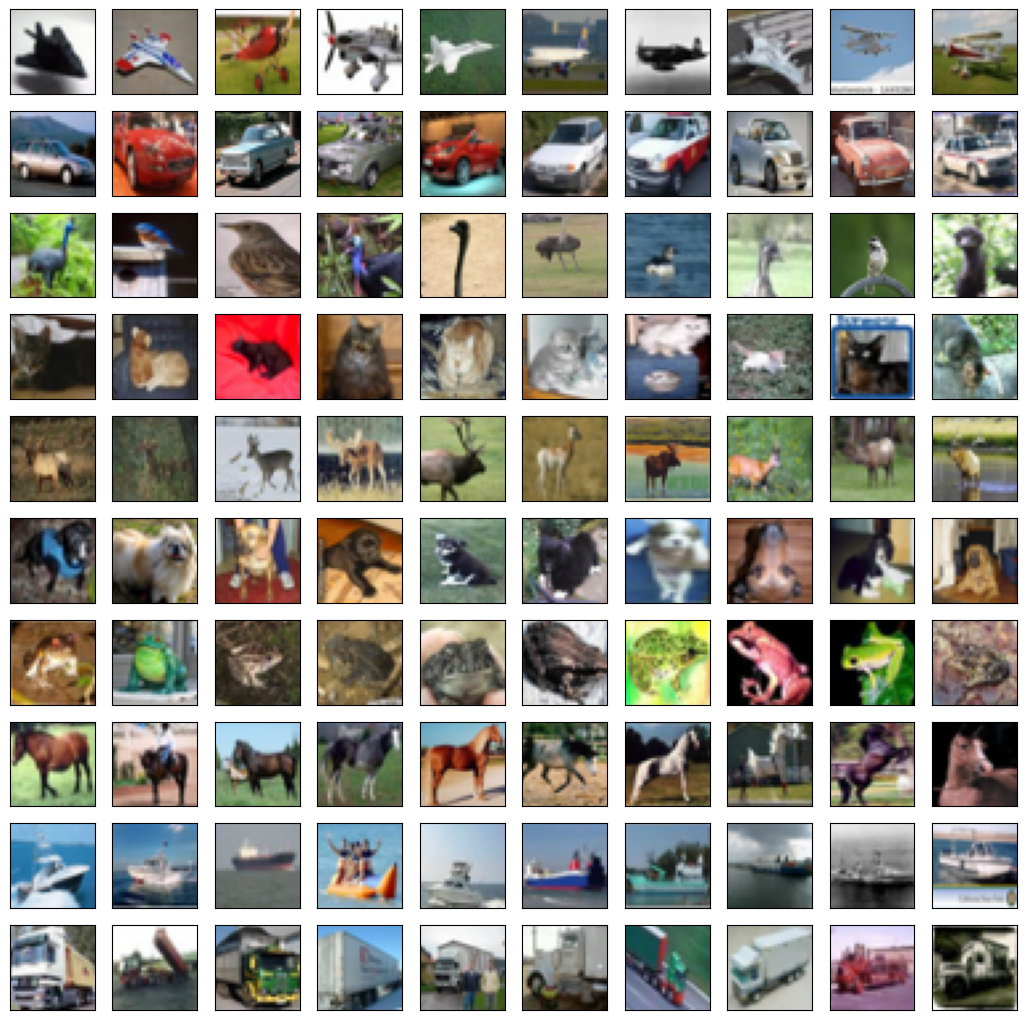

In [2]:
num_classes = 10
fig, axes = plt.subplots(num_classes, 10, figsize=(13, 13))
labels = np.array([t[1] for t in trainset])
for i in range(num_classes):
    indice = np.where(labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(trainset[indice[j]][0].permute(1, 2, 0).numpy())
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

## 卷积网络的搭建

In [3]:
class CNN(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        # alexnet简化版本
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pooling1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pooling2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(4096, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

## 设置超参数并训练

In [5]:
batch_size = 64
learning_rate = 1e-3
epochs = 8
np.random.seed(0)
torch.manual_seed(0)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = F.cross_entropy

for epoch in range(epochs):
    losses = 0
    accs = 0
    num = 0

    model.train()
    # tqdm是taqaddum的缩写，在阿拉伯语中的意思是 "进展" 或 "前进"
    with tqdm(trainloader) as pbar:
        for data in pbar:
            images, labels = data

            # image:torch.size(64, 3, 32, 32)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num += len(labels)
            losses += loss.detach().numpy() * len(labels)

            accs += (torch.argmax(outputs, dim=-1) == labels).sum().detach().numpy()
            pbar.set_postfix({'Epoch': epoch, 'Train loss': f'{losses / num:.3f}', 'Train acc': f'{accs / num:.3f}'})

    losses = 0
    accs = 0
    num = 0
    model.eval()
    with tqdm(testloader) as pbar:
        for data in pbar:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            num += len(labels)
            losses += loss.detach().numpy() * len(labels)
            accs += (torch.argmax(outputs, dim=-1) \
                     == labels).sum().detach().numpy()
            pbar.set_postfix({'Epoch': epoch, 'Test loss': f'{losses / num:.3f}', 'Test acc': f'{accs / num:.3f}'})

100%|██████████| 157/157 [00:07<00:00, 21.16it/s, Epoch=7, Test loss=0.759, Test acc=0.736]


## Q_a
分别改变learning rate为1e-6 至1e-1，观察影响

In [9]:
for i in range(1, 7):
    learning_rate = 10 ** (- i)
    epochs = 7
    for epoch in range(epochs):
        losses = 0
        accs = 0
        num = 0

        model.train()
        # tqdm是taqaddum的缩写，在阿拉伯语中的意思是 "进展" 或 "前进"
        with tqdm(trainloader) as pbar:
            for data in pbar:
                images, labels = data

                # image:torch.size(64, 3, 32, 32)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                num += len(labels)
                losses += loss.detach().numpy() * len(labels)

                accs += (torch.argmax(outputs, dim=-1) == labels).sum().detach().numpy()
                pbar.set_postfix(
                    {'Epoch': epoch, 'Train loss': f'{losses / num:.3f}', 'Train acc': f'{accs / num:.3f}'})

        losses = 0
        accs = 0
        num = 0
        model.eval()
        with tqdm(testloader) as pbar:
            for data in pbar:
                images, labels = data
                outputs = model(images)
                loss = criterion(outputs, labels)
                num += len(labels)
                losses += loss.detach().numpy() * len(labels)
                accs += (torch.argmax(outputs, dim=-1) \
                         == labels).sum().detach().numpy()
                pbar.set_postfix({'Epoch': epoch, 'learning rate': learning_rate, 'Test loss': f'{losses / num:.3f}',
                                  'Test acc': f'{accs / num:.3f}'})




100%|██████████| 157/157 [00:07<00:00, 20.82it/s, Epoch=6, learning rate=1e-6, Test loss=0.700, Test acc=0.791]


## Q_b
以下代码对cifar10进行数据增强并处理，但是由于跑的时间比较长，还没有验证结果是否有效，仅展示数据增广部分的代码。但是一定是有必要进行数据增广的。因为CNN神经网络主要是对颜色和纹路进行拟合，而对整体轮廓的拟合不高。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# 下载训练集和测试集
data_path = './cifar10'
trainset = CIFAR10(root=data_path, train=True, download=True, transform=transforms.ToTensor())
testset = CIFAR10(root=data_path, train=False, download=True, transform=transforms.ToTensor())
print('训练集大小：', len(trainset))
print('测试集大小：', len(testset))

num_classes = 10
# # 将增强数据集添加到原始数据集中
# full_dataset = original_dataset + augmented_dataset

transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2),  # 亮度调整（随机亮度）
    transforms.RandomRotation(degrees=45),  # 随机旋转
    # transforms.RandomResizedCrop(size=(256, 256)),
    # 别随机裁剪！ 随机裁剪和缩放之后人都认不出来是什么
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
])

new_dataset = []
cnt = 0
with tqdm(trainset) as pbar:
    for image, label in trainset:
        cnt += 1
        # 应用相同的数据增强转换器生成增强样本
        augmented_image = transform(image)
        new_dataset.append((augmented_image, label))
        pbar.set_postfix({'cnt=': cnt})

trainset = trainset + new_dataset


## Q_d
极小卷积核通常指的是大小为1x1的卷积核，这种卷积核在CNN中常用于降低通道数或者进行特征图的线性组合.

In [ ]:
class CNN(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        # alexnet简化版本
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 2, padding=1) ## 卷积核大小为2
        self.pooling1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 2, padding=1)
        self.pooling2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(4096, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

极大卷积核通常指的是大小为输入矩阵的尺寸的卷积核，或者更大的尺寸。这种卷积核在 CNN 中可以用于实现池化（ pooling ）的效果。（没有时间跑结果了）

In [ ]:
class CNN(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        # alexnet简化版本
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 16, padding=1) ## 卷积核大小为16
        self.pooling1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 16, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 16, padding=1)
        self.pooling2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(4096, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x